In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup

In [69]:
headers = ['polarity', 'headline', 'content']
df = pd.read_csv('C:/Users/aso/Documents/WPy-376/notebooks/NLP - Python/data/row_data/train.csv', names=headers)
df.head()
df.polarity.value_counts()

4    30000
3    30000
2    30000
1    30000
Name: polarity, dtype: int64

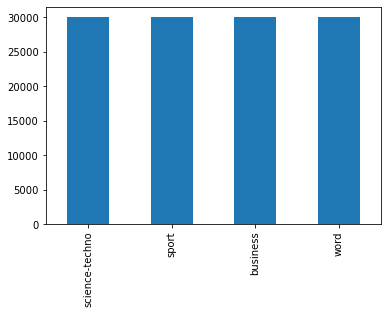

In [70]:
df.loc[df['polarity'] == 1 ,['polarity']] = 'word'
df.loc[df['polarity'] == 2 ,['polarity']] = 'sport'
df.loc[df['polarity'] == 3 ,['polarity']] = 'business'
df.loc[df['polarity'] == 4 ,['polarity']] = 'science-techno'

df.head()
df['polarity'].value_counts().sort_values(ascending=False).plot(kind='bar')

In [71]:
df.head(n=10)

,polarity,headline,content
0,business,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
5,business,"Stocks End Up, But Near Year Lows (Reuters)",Reuters - Stocks ended slightly higher on Frid...
6,business,Money Funds Fell in Latest Week (AP),AP - Assets of the nation's retail money marke...
7,business,Fed minutes show dissent over inflation (USATO...,USATODAY.com - Retail sales bounced back a bit...
8,business,Safety Net (Forbes.com),Forbes.com - After earning a PH.D. in Sociolog...
9,business,Wall St. Bears Claw Back Into the Black,"NEW YORK (Reuters) - Short-sellers, Wall Stre..."


### mytokenize function

In [72]:
def mytokenize(df):

    df['text'] = df['headline'] + df['content']
    df.drop(columns=[col for col in df.columns if col not in ['polarity','text']], inplace=True)
    
    df = df.reset_index(drop=True)
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))

    def clean_text(text):
        text = text.lower()
        text = REPLACE_BY_SPACE_RE.sub(' ', text) 
        text = BAD_SYMBOLS_RE.sub('', text)
        text = text.replace('x', '')
        text = ' '.join(word for word in text.split() if word not in STOPWORDS)
        return text
    
    df['text'] = df['text'].apply(clean_text)
    df['text'] = df['text'].str.replace('\d+', '')
    
    # The maximum number of words to be used. (most frequent)
    MAX_NB_WORDS = 50000
    # Max number of words in each complaint.
    MAX_SEQUENCE_LENGTH = 250
    # This is fixed.
    EMBEDDING_DIM = 100

    tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(df['text'].values)
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    
    
    X = tokenizer.texts_to_sequences(df['text'].values)
    X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
    print('Shape of data tensor:', X.shape)
    
    Y = pd.get_dummies(df['polarity']).values
    print('Shape of label tensor:', Y.shape)
    
    return X , Y

### Load train set 

In [73]:
headers = ['polarity', 'headline', 'content']
df_train = pd.read_csv('C:/Users/aso/Documents/WPy-376/notebooks/NLP - Python/data/row_data/train.csv', names=headers)
X_train, Y_train =  mytokenize(df_train)
print(X_train.shape,Y_train.shape)

Found 152567 unique tokens.
Shape of data tensor: (120000, 250)
Shape of label tensor: (120000, 4)
(120000, 250) (120000, 4)


### Load test set 

In [74]:
headers = ['polarity', 'headline', 'content']
df_test = pd.read_csv('C:/Users/aso/Documents/WPy-376/notebooks/NLP - Python/data/row_data/test.csv', names=headers)
X_test, Y_test =  mytokenize(df_test)
print(X_test.shape,Y_test.shape)

Found 28635 unique tokens.
Shape of data tensor: (7600, 250)
Shape of label tensor: (7600, 4)
(7600, 250) (7600, 4)


### Definition of model architec

In [75]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 404       
Total params: 5,080,804
Trainable params: 5,080,804
Non-trainable params: 0
_________________________________________________________________
None


### Fit train set

Train on 84000 samples, validate on 36000 samples
Epoch 1/2
84000/84000 [==============================] - 1663s 20ms/step - loss: 0.3814 - accuracy: 0.8713 - val_loss: 0.2869 - val_accuracy: 0.9011
Epoch 2/2
84000/84000 [==============================] - 1683s 20ms/step - loss: 0.2020 - accuracy: 0.9343 - val_loss: 0.3055 - val_accuracy: 0.8959


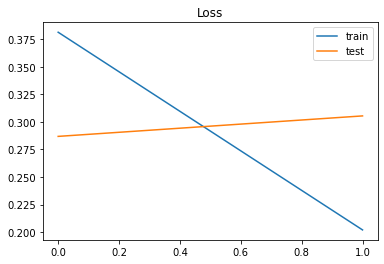

KeyError: 'acc'

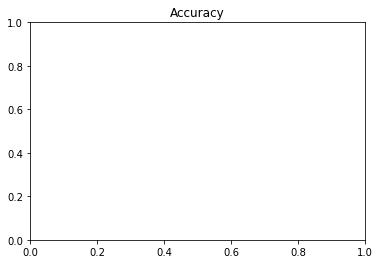

In [76]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.3,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

### Evaluate test set

In [77]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

7600/7600 [==============================] - 37s 5ms/step
Test set
  Loss: 2.661
  Accuracy: 0.283
